In [1]:
import requests 
from zeep import Client
from zeep.transports import Transport
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pds
from datetime import datetime
from multiprocessing import dummy
import time
import xmltodict

In [133]:
class AMDA_soap:
    def __init__(self, WSDL='http://amda.irap.omp.eu/AMDA/public/wsdl/Methods_AMDA.wsdl'):
        self.soap_client = Client(WSDL)

    def getParameter(self, **kwargs):
        resp = self.soap_client.service.getParameter(**kwargs).__json__()
        if resp["success"]:
            return resp["dataFileURLs"][0]
        else:
            return None

    def getObsDataTree(self):
        resp = self.soap_client.service.getObsDataTree().__json__()
        if resp["success"]:
            return resp["WorkSpace"]["LocalDataBaseParameters"]
        else:
            return None

def listify(list_or_obj):
    if type([]) == type(list_or_obj):
        return list_or_obj
    else:
        return [list_or_obj]

class AMDA_REST:
    def __init__(self, server_url="http://amda.irap.omp.eu/php/rest/"):
        self.server_url = server_url

    def getParameter(self, **kwargs):
        url = self.server_url + "/getParameter.php?"
        for key, val in kwargs.items():
            url += key + "=" + str(val) + "&"
        r = requests.get(url)
        for i in range(5):
            r = requests.get(url)
            if "http" in r.text:
                break
        return r.text

    def getObsDataTree(self):
        url = self.server_url + "/getObsDataTree.php"
        r = requests.get(url)
        return r.text.split(">")[1].split("<")[0]


class AMDA:
    METHODS = {
        "REST": AMDA_REST(),
        "SOAP": AMDA_soap()
    }

    def __init__(self):
        pass

    def getParameter(self, startTime, stopTime, parameterID, method="SOAP", **kwargs):
        if type(startTime) is datetime:
            startTime = startTime.isoformat()
        if type(stopTime) is datetime:
            stopTime = stopTime.isoformat()
        url = self.METHODS[method.upper()].getParameter(
            startTime=startTime, stopTime=stopTime, parameterID=parameterID, **kwargs)
        if not url is None:
            return pds.read_csv(url, delim_whitespace=True, comment='#', parse_dates=True, infer_datetime_format=True, index_col=0, header=None)
        return None

    def getObsDataTree(self, method="SOAP"):
        datatree = xmltodict.parse(requests.get(
            self.METHODS[method.upper()].getObsDataTree()).text)
        for mission in datatree["dataRoot"]["dataCenter"]["mission"]:
            for instrument in listify(mission["instrument"]):
                for dataset in listify(instrument['dataset']):
                    for parameter in listify(dataset['parameter']):
                        if 'component' in parameter:
                            parameter['component'] = {
                                comp["@name"] : comp for comp in listify(parameter['component'])
                            }
                    dataset['parameter'] = {
                        param["@name"]: param for param in listify(dataset['parameter'])}
                instrument['dataset'] = {
                    dataset["@name"]: dataset for dataset in listify(instrument['dataset'])}
            mission["instrument"] = {
                instrument["@name"]: instrument for instrument in listify(mission["instrument"])}
        datatree["dataRoot"]["dataCenter"]["mission"] = {
            mission["@name"]: mission for mission in datatree["dataRoot"]["dataCenter"]["mission"]}
        return datatree


def amda_getParameter_frag_wrapper(args):
    amda = AMDA()
    return amda.getParameter(**args)

# Convenience method to split download in "nfrag" fragments
def amda_getParameter_frag(startTime, stopTime, parameterID, nfrags, method="rest"):
    frag_size = (stopTime - startTime) / nfrags
    time_ranges = [{"startTime": startTime + (k * frag_size), "stopTime": startTime + (
        (k + 1) * frag_size), "parameterID": parameterID, "method": method} for k in range(nfrags)]
    pool = dummy.Pool(nfrags)
    return pds.concat(pool.map(amda_getParameter_frag_wrapper, time_ranges))

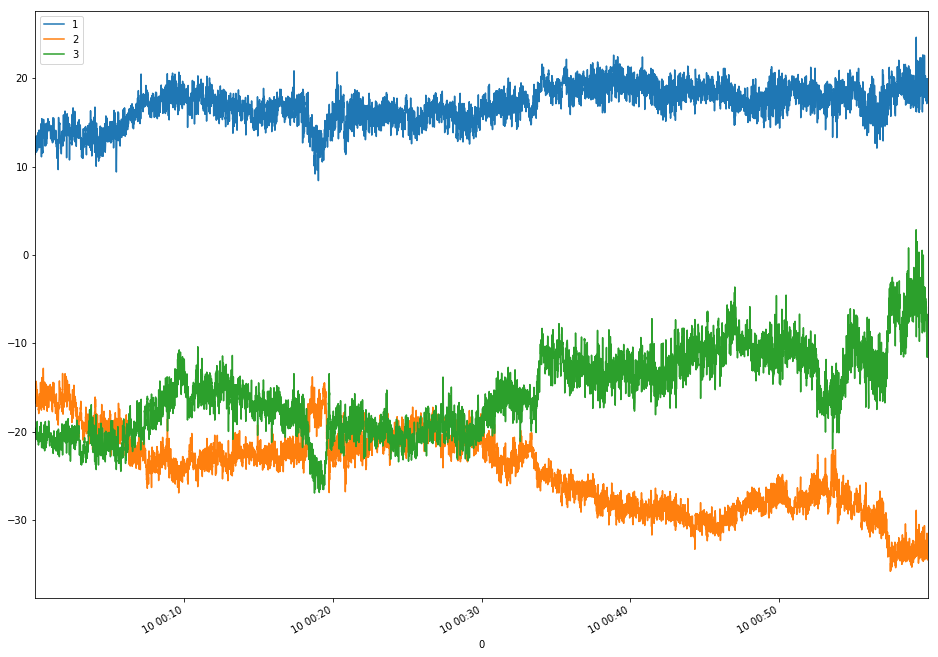

In [145]:
startdate=datetime(2011,12,10)
stopdate=datetime(2011,12,10,1)
parameterID = "c1_b_5vps"
amda = AMDA() 
c1_b_5vps = amda.getParameter(startTime=startdate,stopTime=stopdate,parameterID=parameterID,method="REST")
c1_b_5vps.plot(figsize=(16,12))

In [146]:
datatree=amda.getObsDataTree(method="SOAP")
datatree["dataRoot"]["dataCenter"]["mission"]["CLUSTER1"]['instrument']\
    ["FGM"]['dataset']["fgm_5vps"]["parameter"]["b_gse"]["component"]


{'bx': OrderedDict([('@name', 'bx'), ('@xml:id', 'c1_b_5vps(0)')]),
 'by': OrderedDict([('@name', 'by'), ('@xml:id', 'c1_b_5vps(1)')]),
 'bz': OrderedDict([('@name', 'bz'), ('@xml:id', 'c1_b_5vps(2)')])}

In [152]:
[mission for mission in datatree["dataRoot"]["dataCenter"]["mission"]]


['ICE@Giacobini-Zinner',
 'Giotto@Halley',
 'Rosetta',
 'Cassini',
 'Galileo',
 'Solar Probe Plus',
 'Solar Orbiter',
 'Juice',
 'Juno',
 'Rosetta @ C-G',
 'Juno : cruise',
 'Mercury',
 'Venus',
 'Mars',
 'Jupiter',
 'Saturn',
 'Voyager_1',
 'Voyager_2',
 'Pioneer_10',
 'Pioneer_11',
 'PVO',
 'VEX',
 'MEX',
 'MGS',
 'MAVEN',
 'Exomars',
 'MMS1',
 'MMS2',
 'MMS3',
 'MMS4',
 'BepiColombo',
 'MESSENGER@PDS',
 'ULYSSES',
 'Stereo-A',
 'Stereo-B',
 'ACE',
 'WIND',
 'THEMIS-A',
 'THEMIS-B',
 'THEMIS-C',
 'THEMIS-D',
 'THEMIS-E',
 'CLUSTER1',
 'CLUSTER2',
 'CLUSTER3',
 'CLUSTER4',
 'DoubleStar1',
 'IMP-8',
 'GEOTAIL',
 'POLAR',
 'INTERBALL-Tail',
 'ISEE-1',
 'ISEE-2',
 'Indices',
 'Geomagnetic Field Models',
 'Mars Crustal Magnetic Field Models',
 'OMNI',
 'Astronomical Objects Ephemerides']